In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import yfinance as yf
from pandas_datareader.data import DataReader


In [50]:
def plot(prediction,target,grey=None,start=None,end=None):
    # if start is None:
    #     start=df.index.min()
    # if end is None:
    #     end=df.index.max()
    # recessions=DataReader('USREC', 'fred', start=start,end=end)['USREC']

    # pd.concat([,target],axis=1,ignore_index=False).plot()
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    
    # if isinstance(df,pd.DataFrame):
    # else:
    #     ylim = (df.min(),df.max())
        

    Results=pd.DataFrame(prediction,index=target.index)
    Results.plot(ax=ax,legend=True)
    Results['target']=target
    ylim = (0,1)
    ax.fill_between(Results['target'].index, 0, ylim[1]+1e-2, Results['target'],facecolor='k', alpha=0.1)
    ax.legend(["Prediction", "NBER recession indicator"])
    return fig,ax

<Axes: xlabel='DATE'>

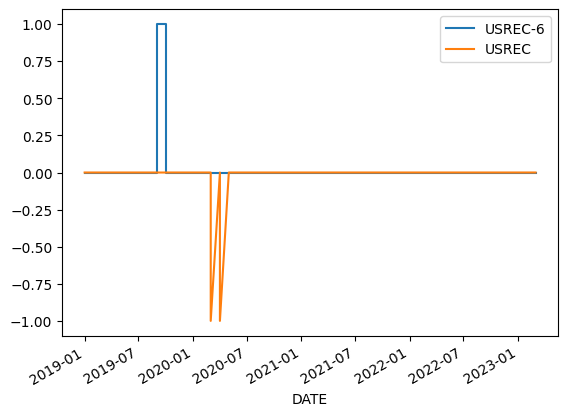

In [51]:
pd.concat([recessions.shift(-6).rename(columns={'USREC':'USREC-6'}),-1*recessions]).fillna(0).loc['2019':].plot()

In [52]:
# df=yf.download("GE")
# df.head()
n_lookback=30
n_forecast=1

df=pd.read_csv('Data/Transformed HistoricalVariables.csv',index_col=0)
recessions =  DataReader('USREC', 'fred', start='1800')
df[f'target-{n_forecast}']=recessions.shift(n_forecast)
df['target'] = recessions
df.index=pd.DatetimeIndex(df.index)
df.fillna(method='ffill',inplace=True)
# df=df.fillna(-1)
df=df['1972':]
print(df.shape)
df.head()

(10996, 126)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio,target-1,target
1972-01-01,0.004807,0.005647,0.000101,0.010515,NaN,0.023685,0.019348,0.018658,0.014934,0.029464,...,0.0,0.007845,-0.007407,-0.004527,0.008296,NaN,0.0,0.034457,0.0,0.0
1972-01-08,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,-0.007845,0.007407,0.004527,-0.008296,NaN,0.0,0.000000,0.0,0.0
1972-01-15,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.0,0.0
1972-01-22,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.0,0.0
1972-01-29,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.0,0.0


In [53]:
test_split=round(len(df)*0.20)
df_for_training=df[:"2006"]
df_for_testing=df["2006":"2021"]
print('df_for_training shape: ',df_for_training.shape)
print('df_for_testing shape: ',df_for_testing.shape)

df_for_training shape:  (5849, 126)
df_for_testing shape:  (5065, 126)


In [54]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
# df_for_training_scaled[np.isnan(df_for_training_scaled)] = -1
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))
# df_for_testing_scaled[np.isnan(df_for_testing_scaled)] = -1


In [55]:
def createXY(dataset,n_lookback = 60,n_forecast = 3,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:dataset.shape[1]-1])
        Y.append(dataset[i: i + n_forecast,target_col])

    return np.array(X),np.array(Y)



In [56]:
trainX,trainY=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX,testY=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)

In [57]:
n_forecast

1

In [58]:
dataset=[*range(300)]
Y=[]
for i in range(n_lookback, len(dataset) - n_forecast + 1):
    Y.append(dataset[i: i + n_forecast])
Y=np.array(Y)
Y[:,-1]

array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21

In [59]:
pd.DatetimeIndex

pandas.core.indexes.datetimes.DatetimeIndex

Epoch 1/10
164/164 [==============================] - 14s 48ms/step - loss: 0.3195 - val_loss: 0.0399
Epoch 2/10
164/164 [==============================] - 7s 45ms/step - loss: 0.1524 - val_loss: 0.0014
Epoch 3/10
164/164 [==============================] - 7s 46ms/step - loss: 0.1192 - val_loss: 0.0100
Epoch 4/10
164/164 [==============================] - 8s 48ms/step - loss: 0.1023 - val_loss: 0.0125
Epoch 5/10
164/164 [==============================] - 7s 45ms/step - loss: 0.1038 - val_loss: 0.0028
Epoch 6/10
164/164 [==============================] - 7s 45ms/step - loss: 0.0977 - val_loss: 0.0025
Epoch 7/10
164/164 [==============================] - 7s 42ms/step - loss: 0.1078 - val_loss: 0.0132
Epoch 8/10
164/164 [==============================] - 7s 44ms/step - loss: 0.1690 - val_loss: 0.0327
Epoch 9/10
164/164 [==============================] - 8s 48ms/step - loss: 0.1095 - val_loss: 2.4719e-04
Epoch 10/10
164/164 [==============================] - 8s 49ms/step - loss: 0.0918 - v

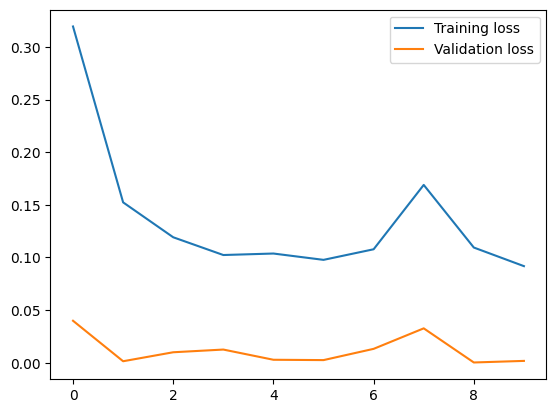

In [60]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(n_forecast,activation='sigmoid'))

model.compile(optimizer='adam', loss='BinaryCrossentropy')
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [61]:
prediction=model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)
print("\nMax and min",prediction.max(),prediction.min())


158/158 [==============================] - 3s 16ms/step
prediction
 [[0.00069753]
 [0.00071113]
 [0.00072207]
 ...
 [0.00017331]
 [0.00017118]
 [0.00016969]]

Prediction Shape- (5035, 1)

Max and min 0.9914671 9.554657e-05


In [62]:
prediction_train=model.predict(trainX)
print("prediction_train\n", prediction_train)
print("\nPrediction Shape-",prediction_train.shape)

182/182 [==============================] - 3s 18ms/step
prediction_train
 [[0.00012169]
 [0.00013928]
 [0.00013673]
 ...
 [0.00621885]
 [0.00620099]
 [0.00618626]]

Prediction Shape- (5819, 1)


In [63]:
prediction_train.max()

0.98986256

(<Figure size 3000x1800 with 1 Axes>, <Axes: >)

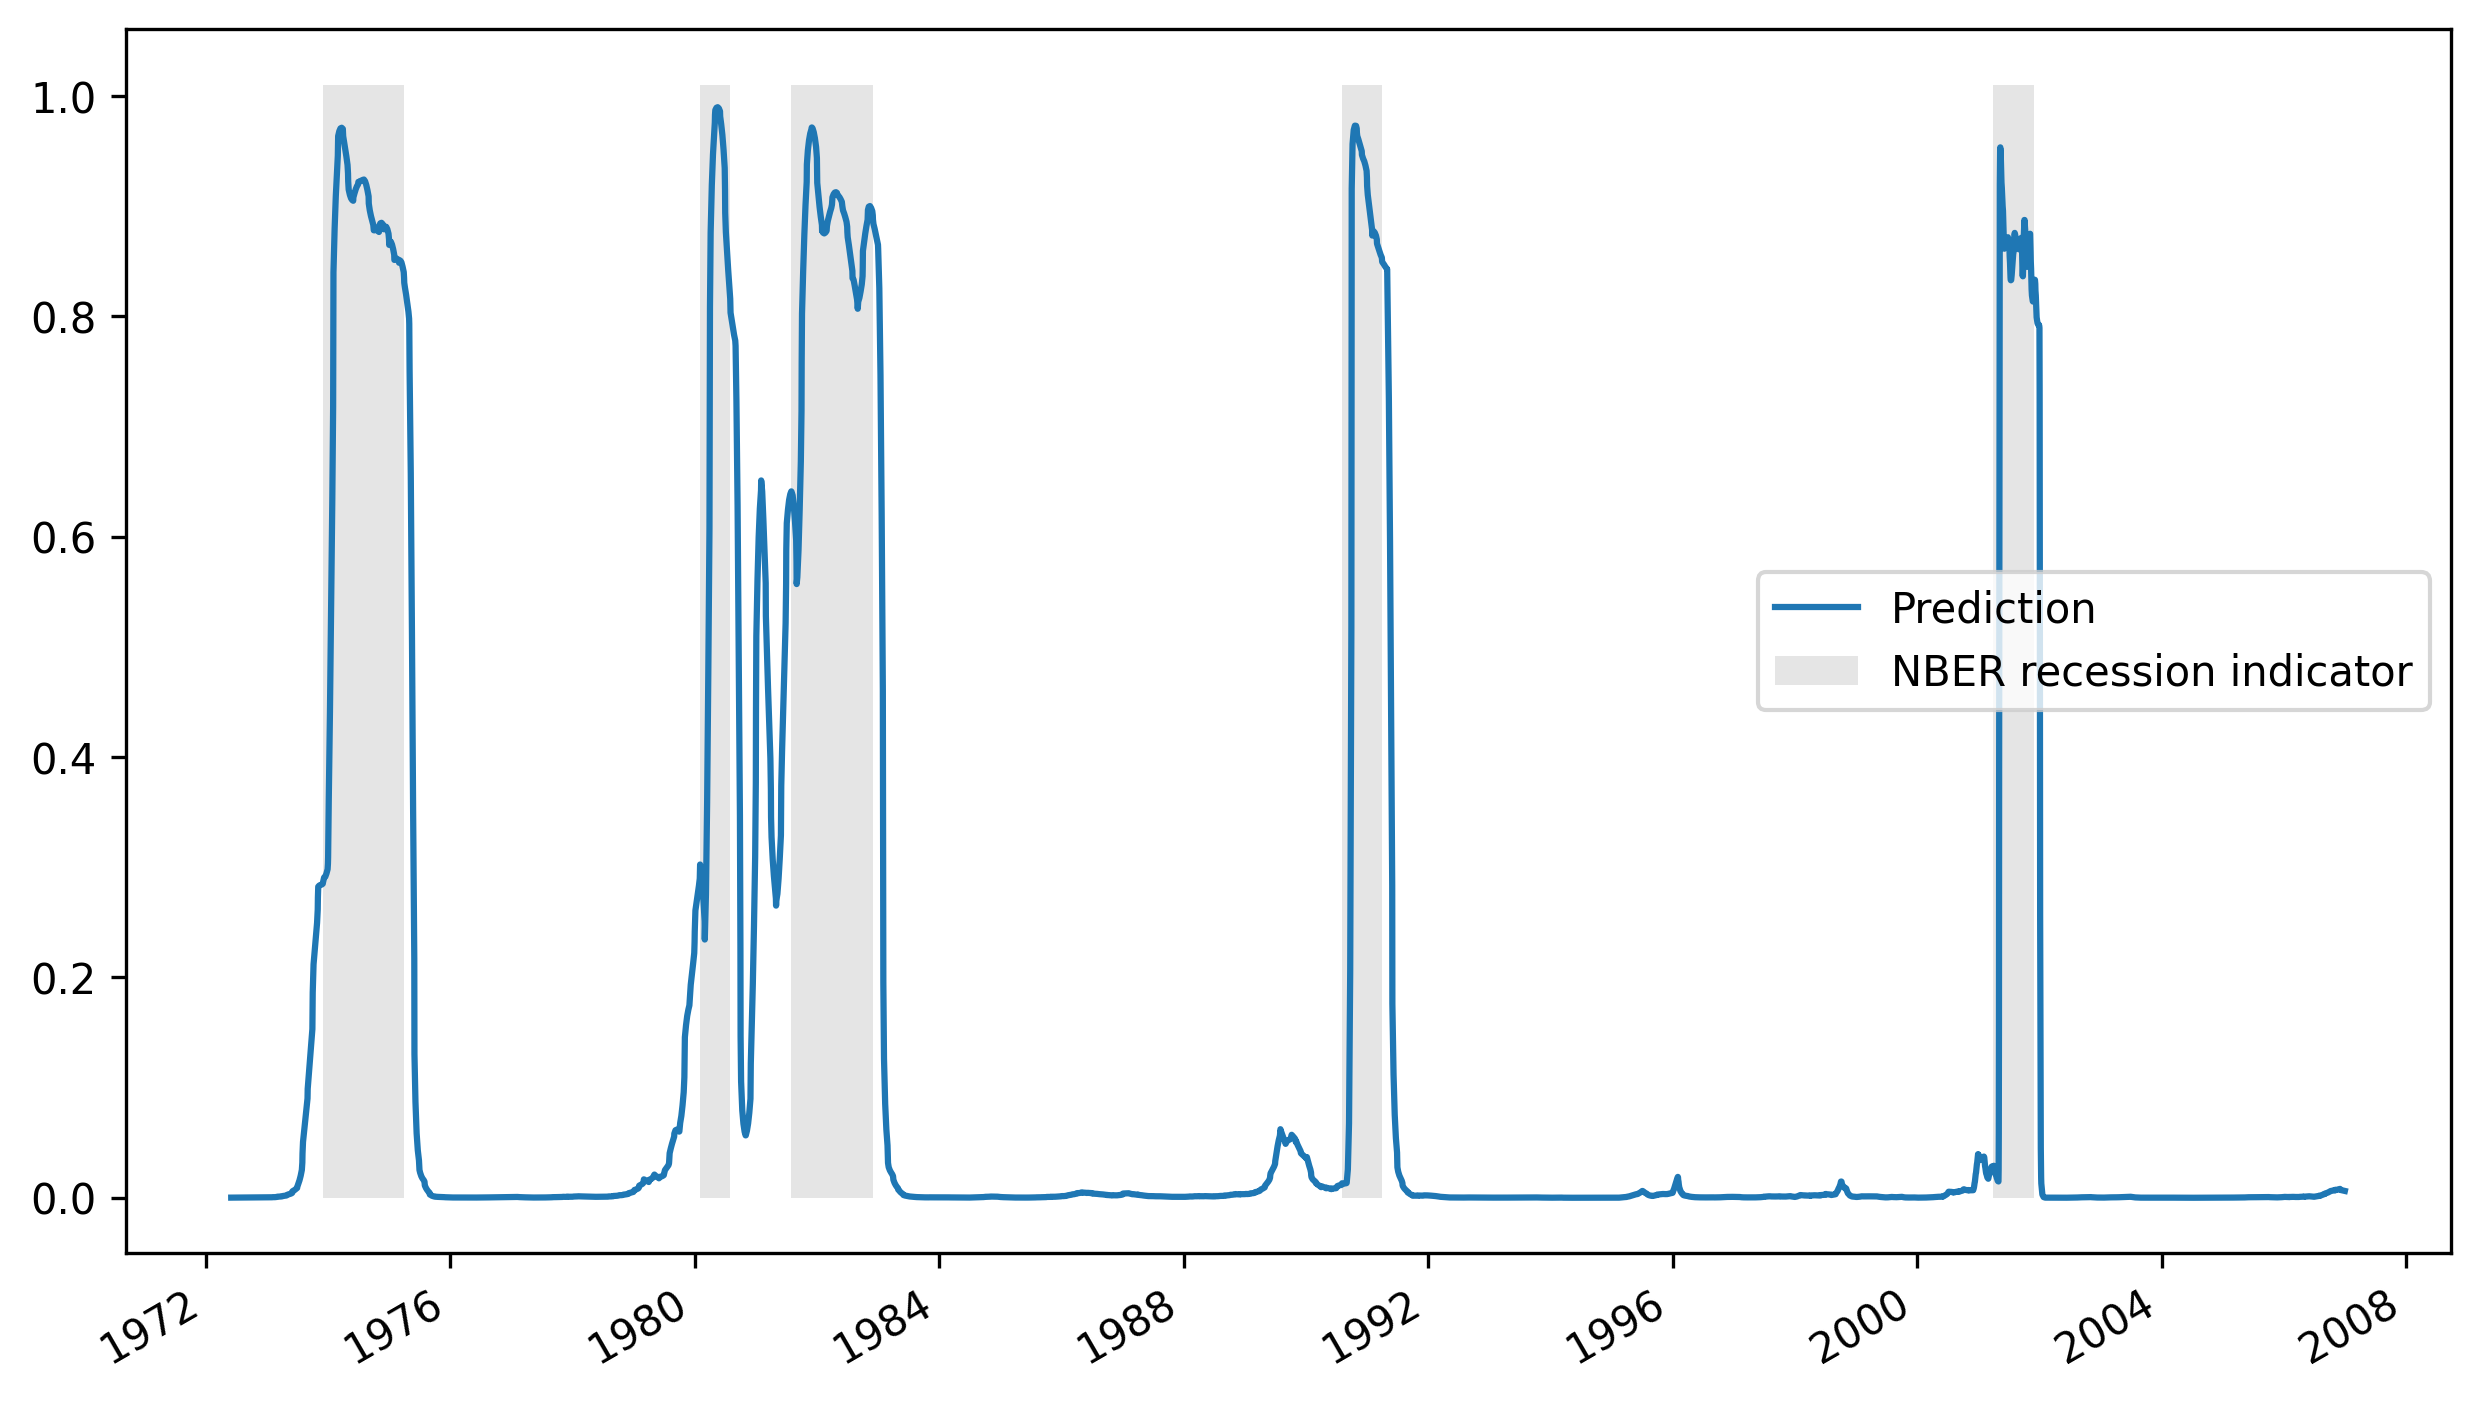

In [64]:
plot(prediction_train,df_for_training["target"].iloc[-prediction_train.shape[0]:])

In [65]:
# df_for_training["target"].plot(figsize=(13,3))
# plt.plot(*prediction_train, color = 'red', label = 'Predicted')

# plt.title('Recession Prediction')
# plt.xlabel('Time')
# plt.ylabel('Is A recession?')
# plt.legend()
# plt.show()

(<Figure size 3000x1800 with 1 Axes>, <Axes: >)

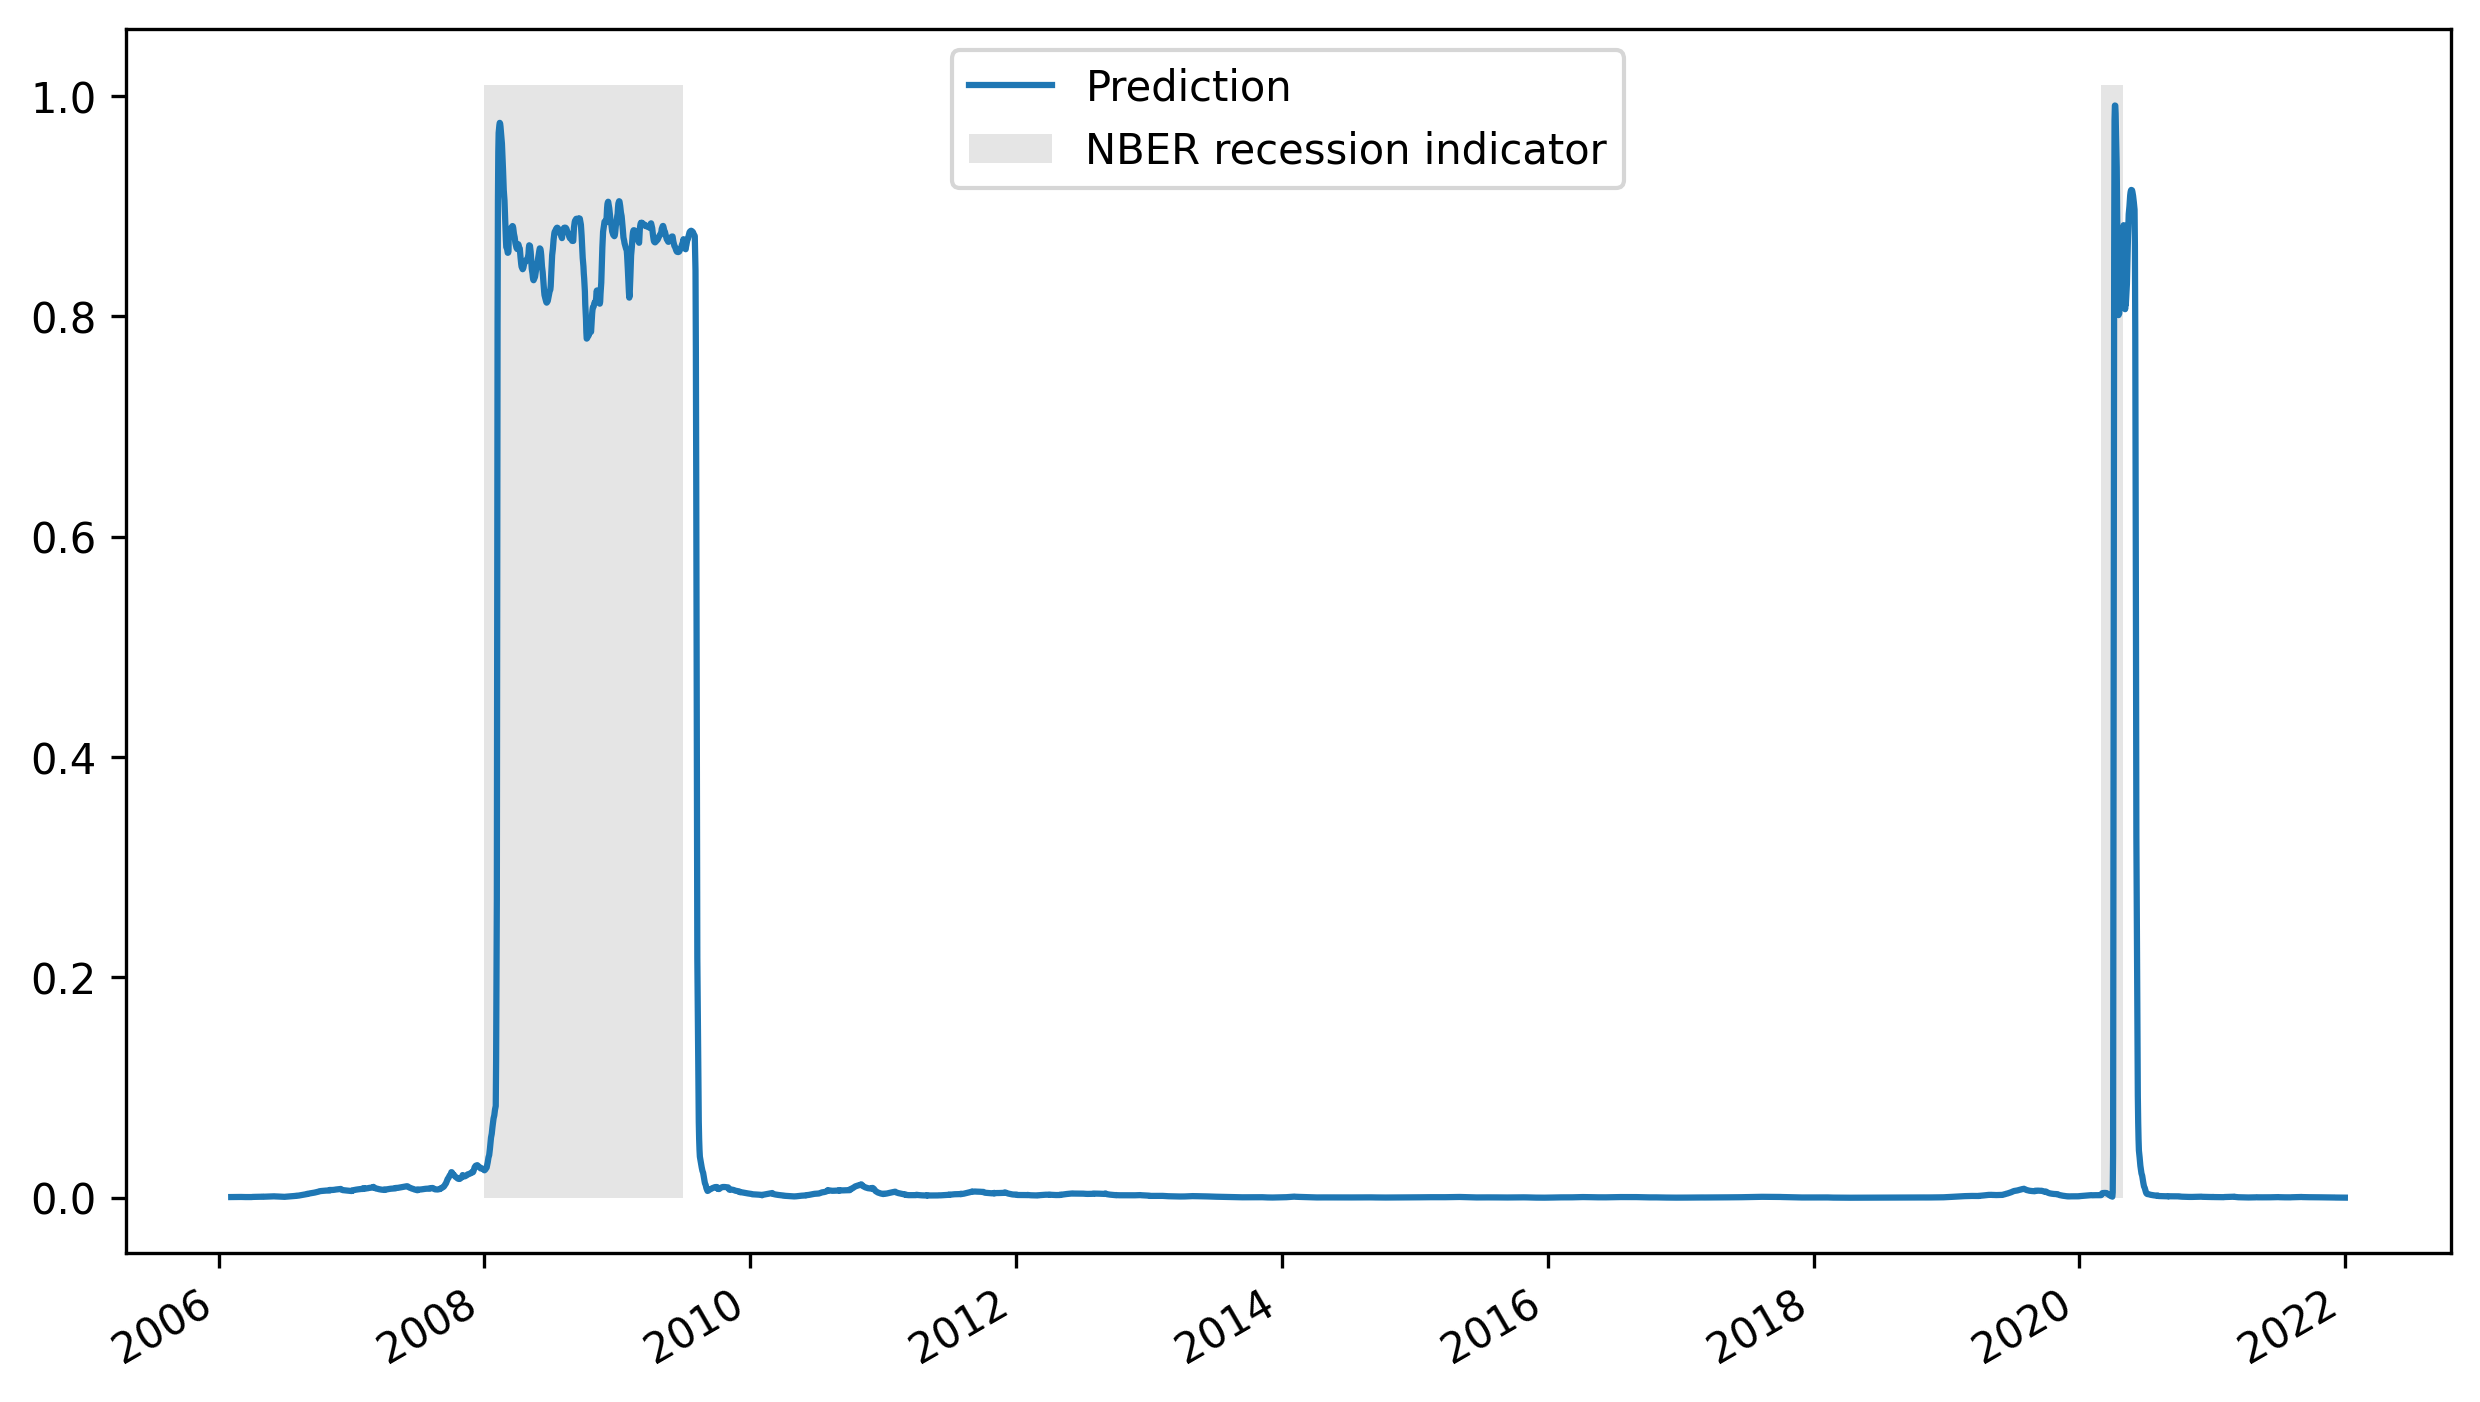

In [66]:
plot(prediction,df_for_testing["target"].iloc[-prediction.shape[0]:])

In [67]:
break
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming you have your historical GDP data in a numpy array called 'gdp_data'
# with shape (num_samples, num_features)

# Split the data into input (X) and target (y) sequences
sequence_length = 10  # Number of previous days to consider as input
forecast_length = 180  # Number of days to forecast
target_column = -1  # Index of the target column in the dataset

# Generate X and y using the createXY function
X, y = createXY(gdp_data, n_lookback=sequence_length, n_forecast=forecast_length, target_col=target_column)

# Normalize the data (optional but often beneficial for neural networks)
X_norm = (X - np.mean(X)) / np.std(X)
y_norm = (y - np.mean(y)) / np.std(y)

# Split the data into training and test sets
train_size = int(0.8 * len(X_norm))
X_train, X_test = X_norm[:train_size], X_norm[train_size:]
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Define the model
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, gdp_data.shape[1]-1)))
model.add(Dense(forecast_length))  # Output layer with 'forecast_length' units for predicting the next 'forecast_length' days

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# Assuming you have your latest sequence of GDP data in a numpy array called 'latest_data'
# with shape (sequence_length, num_features)

# Predict the next 'forecast_length' days
latest_data_norm = (latest_data - np.mean(X)) / np.std(X)
latest_data_norm = np.reshape(latest_data_norm, (1, sequence_length, gdp_data.shape[1]-1))
predicted_data_norm = model.predict(latest_data_norm)
predicted_data = (predicted_data_norm * np.std(y)) + np.mean(y)

# The 'predicted_data' will be a numpy array with shape (1, forecast_length),
# containing the predicted GDP values for the next 'forecast_length' days.


SyntaxError: 'break' outside loop (458900137.py, line 1)